In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import chi2_contingency
import geocoder


In [2]:
%reload_kedro

2021-04-18 10:09:40,896 - root - INFO - Registered hooks from 2 installed plugin(s): kedro-mlflow-0.7.0
2021-04-18 10:09:40,902 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.


/Users/xszpo/miniconda3/envs/viabill/lib/python3.8/site-packages/kedro/framework/project/__init__.py:133: UserWarning: Found duplicate pipeline entries. The following will be overwritten: __default__
  warn(


2021-04-18 10:09:41,028 - root - INFO - ** Kedro project viabill
2021-04-18 10:09:41,031 - root - INFO - Defined global variable `context`, `session` and `catalog`
2021-04-18 10:09:41,055 - root - INFO - Registered line magic `run_viz`


## Load data


In [3]:
df_cust = catalog.load("customers")
d_sex = {1: 'male', 2:'female', 0: 'other'}
df_cust.sex = df_cust.sex.apply(lambda x: d_sex[x])

df_cust['residentialAddress_clean'] = df_cust.residentialAddress.apply(lambda x: re.sub(r'[0-9]+', '', x))
df_cust['postalAddress_clean']  = df_cust.postalAddress.apply(lambda x: re.sub(r'[0-9]+', '', x) if x==x else '')
df_cust['same_address'] = (df_cust.residentialAddress==df_cust.postalAddress).astype(int)


2021-04-18 10:09:41,142 - kedro.io.data_catalog - INFO - Loading data from `customers` (CSVDataSet)...


In [4]:
df_trans = catalog.load("transactions")
df_trans['late'] = df_trans.filter(regex='payment').apply(lambda x: x==1).any(axis=1).astype(int)
df_trans['default'] = df_trans.filter(regex='payment').apply(lambda x: x==2).any(axis=1).astype(int)

2021-04-18 10:09:47,631 - kedro.io.data_catalog - INFO - Loading data from `transactions` (CSVDataSet)...
2021-04-18 10:09:50,023 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


In [5]:
#df_trans = catalog.load("transactions")
#d_paymentStatus = {0: 'ok', 1:'late', 2: 'default'}
#df_trans.paymentStatus1 = df_trans.paymentStatus1.map(lambda x: d_paymentStatus[x])
#df_trans.paymentStatus2 = df_trans.paymentStatus2.map(lambda x: d_paymentStatus[x])
#df_trans.paymentStatus3 = df_trans.paymentStatus3.map(lambda x: d_paymentStatus[x])
#df_trans.paymentStatus4 = df_trans.paymentStatus4.map(lambda x: d_paymentStatus[x])

In [6]:
len(df_cust.customerID.unique())

500000

In [7]:
len(df_trans.customerID.unique())

490534

## Customers

In [8]:
df_cust.head()

,customerID,sex,age,residentialAddress,postalAddress,income,residentialAddress_clean,postalAddress_clean,same_address
0,1,male,25,28 Irvine Place,28 Irvine Place,NaN,Irvine Place,Irvine Place,1
1,2,male,19,72 Bertha Street,72 Bertha Street,43200.0,Bertha Street,Bertha Street,1
2,3,female,22,63 Ladberry Street,63 Ladberry Street,70200.0,Ladberry Street,Ladberry Street,1
3,4,other,24,98 Linneman Close,98 Linneman Close,93900.0,Linneman Close,Linneman Close,1
4,5,male,53,56 Salonica Road,56 Salonica Road,77000.0,Salonica Road,Salonica Road,1


In [9]:
print("Nulls percentage:")
(df_cust.replace('',np.nan).isna().sum()/ df_cust.shape[0]).map(lambda x:'{:.2f}%'.format(x*100))

Nulls percentage:


customerID                  0.00%
sex                         0.00%
age                         0.00%
residentialAddress          0.00%
postalAddress               2.02%
income                      1.99%
residentialAddress_clean    0.00%
postalAddress_clean         2.02%
same_address                0.00%
dtype: object

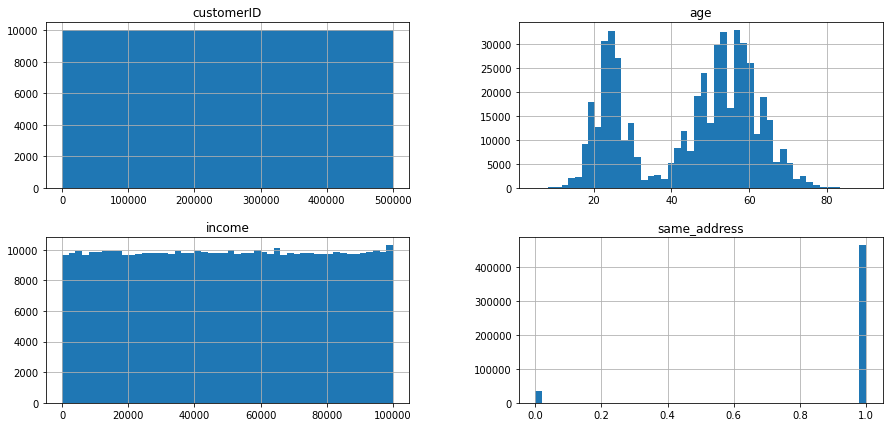

In [10]:
%matplotlib inline
df_cust.hist(bins=50, figsize=(15,7)) 
plt.show()

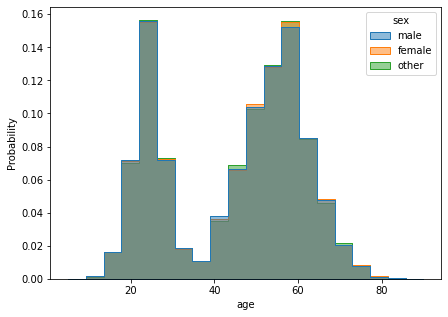

In [11]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(df_cust, x="age", hue="sex", ax=ax, alpha=0.5, bins=20, element="step", stat="probability", common_norm=False)
plt.show()

In [12]:
_tmp = pd.crosstab(df_cust.sex, pd.cut(df_cust.age, 7), rownames=['sex'], colnames=['age'])
_tmp

age,"(4.915, 17.143]","(17.143, 29.286]","(29.286, 41.429]","(41.429, 53.571]","(53.571, 65.714]","(65.714, 77.857]","(77.857, 90.0]"
sex,,,,,,,
female,1778,28840,5806,25381,32238,6095,190
male,6574,108134,22081,94778,119441,22950,587
other,438,7246,1408,6409,8053,1532,41


In [13]:
# Tests whether two categorical variables are related or independent.
# assumptions:
# * Observations used in the calculation of the contingency table are independent.
# 25 or more examples in each cell of the contingency table.
#H0: the two samples are independent.
#H1: there is a dependency between the samples.

# Example of the Chi-Squared Test
table = [_tmp.values]
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=12.594, p=0.399
Probably independent


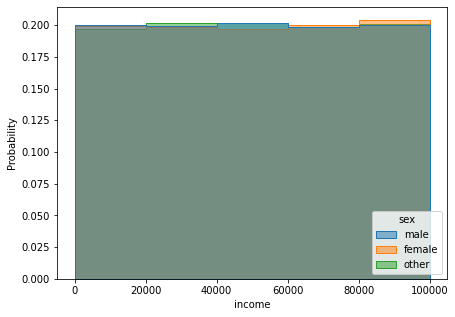

In [14]:
%matplotlib inline

def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    
fig, ax = plt.subplots(figsize=(7,5))
g = sns.histplot(df_cust, x="income", hue="sex", ax=ax, alpha=0.5, bins=5, 
             element="step", stat="probability", common_norm=False)

move_legend(ax, 4)


In [15]:
_tmp = pd.crosstab(df_cust.sex, pd.cut(df_cust.income, 10), rownames=['sex'], colnames=['income'])
_tmp

income,"(-100.0, 10000.0]","(10000.0, 20000.0]","(20000.0, 30000.0]","(30000.0, 40000.0]","(40000.0, 50000.0]","(50000.0, 60000.0]","(60000.0, 70000.0]","(70000.0, 80000.0]","(80000.0, 90000.0]","(90000.0, 100000.0]"
sex,,,,,,,,,,
female,10005,9678,9824,9767,9715,9685,9799,9932,9951,10025
male,36898,37069,36403,36696,36888,36964,36711,36350,36378,36639
other,2461,2418,2485,2493,2425,2539,2517,2383,2342,2585


In [16]:
# Example of the Chi-Squared Test
table = [_tmp.values]
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=40.652, p=0.002
Probably dependent


Highlights:
* there are two customer segments, given age: ~25 years, ~55 years, 
* there's no dependency between age and sex,
* there may be dependency between sex and income, 

## Shops

In [17]:
df_trans.head()

,transactionID,shopID,customerID,price,paymentStatus1,paymentStatus2,paymentStatus3,paymentStatus4,late,default
0,1,114,2869.0,140,0,0,0,0,0,0
1,2,855,124077.0,70,0,0,0,0,0,0
2,3,752,86184.0,85,0,0,0,0,0,0
3,4,246,248861.0,43,1,0,0,0,1,0
4,5,973,162112.0,127,0,0,0,0,0,0


In [18]:
print("Nulls percentage:")
(df_trans.replace('',np.nan).isna().sum()/ df_trans.shape[0]).map(lambda x:'{:.2f}%'.format(x*100))

Nulls percentage:


transactionID     0.00%
shopID            0.00%
customerID        1.00%
price             0.00%
paymentStatus1    0.00%
paymentStatus2    0.00%
paymentStatus3    0.00%
paymentStatus4    0.00%
late              0.00%
default           0.00%
dtype: object

<AxesSubplot:xlabel='shopID', ylabel='transaction_count'>

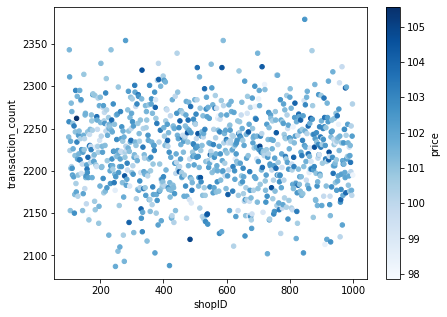

In [19]:
fig, ax = plt.subplots(figsize=(7,5))

df_trans.groupby('shopID').agg(
    transaction_count=('transactionID', 'count'),
    price=('price', 'mean')
).reset_index().plot(x='shopID',y='transaction_count', c= 'price', kind='scatter',colormap="Blues", ax=ax)

Number of transactions and average price are almost the same for all shops.

<AxesSubplot:xlabel='shopID', ylabel='transaction_count'>

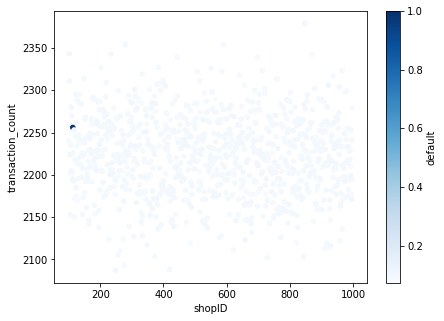

In [20]:
fig, ax = plt.subplots(figsize=(7,5))

df_trans.groupby('shopID').agg(
    transaction_count=('transactionID', 'count'),
    default=('default', 'mean')
).reset_index().plot(x='shopID',y='transaction_count', c= 'default', kind='scatter',colormap="Blues", ax=ax)

There is one shop that seems to be fraud.

In [21]:
df_trans.groupby('shopID').agg(
    transaction_count=('transactionID', 'count'),
    default=('default', 'mean')
).sort_values(by='default').tail(5)

,transaction_count,default
shopID,,
190,2260,0.107080
623,2269,0.107096
658,2123,0.107866
450,2199,0.108686
113,2256,1.000000


Instalments from shop "113" are never paid back- it either corrupted data or fraud.    
I will indicate this shop initially as fraud and will be omitting in further analysis.    


In [22]:
df_trans.loc[df_trans.shopID == 113]

,transactionID,shopID,customerID,price,paymentStatus1,paymentStatus2,paymentStatus3,paymentStatus4,late,default
1701,1702,113,9169.0,9,2,2,2,2,0,1
2530,2531,113,325418.0,122,2,2,2,2,0,1
3567,3568,113,457004.0,123,2,2,2,2,0,1
4577,4578,113,93714.0,70,2,2,2,2,0,1
4723,4724,113,177400.0,96,2,2,2,2,0,1
...,...,...,...,...,...,...,...,...,...,...
1995352,1995353,113,337672.0,80,2,2,2,2,0,1
1996060,1996061,113,120027.0,180,2,2,2,2,0,1
1998490,1998491,113,287125.0,34,2,2,2,2,0,1
1998904,1998905,113,419778.0,180,2,2,2,2,0,1


In [23]:
df_trans['fraud'] = 0
df_trans.loc[df_trans.shopID == 113,'fraud'] = 1

<AxesSubplot:xlabel='shopID', ylabel='transaction_count'>

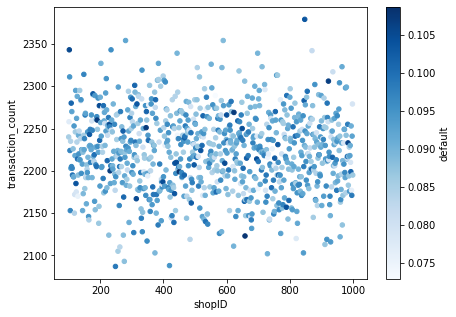

In [24]:
fig, ax = plt.subplots(figsize=(7,5))

df_trans.query("fraud==0").groupby('shopID').agg(
    transaction_count=('transactionID', 'count'),
    default=('default', 'mean')
).reset_index().plot(x='shopID',y='transaction_count', c= 'default', kind='scatter',colormap="Blues", ax=ax)


<AxesSubplot:xlabel='shopID', ylabel='transaction_count'>

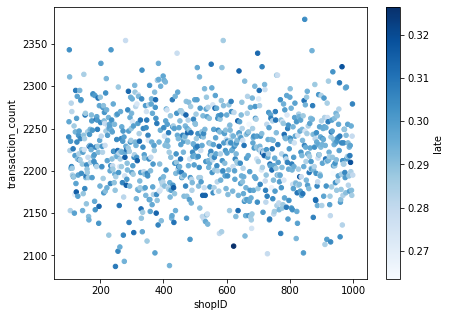

In [25]:
fig, ax = plt.subplots(figsize=(7,5))

df_trans.query("fraud==0").groupby('shopID').agg(
    transaction_count=('transactionID', 'count'),
    late=('late', 'mean')
).reset_index().plot(x='shopID',y='transaction_count', c= 'late', kind='scatter',colormap="Blues", ax=ax)

In [26]:
_tmp = df_trans.query("fraud==0").groupby('shopID').agg(
    transaction_count=('transactionID', 'count'),
    price=('price', 'mean'),
    late=('late', 'mean'),
    default=('default', 'mean')
).reset_index()
_tmp.describe()

,shopID,transaction_count,price,late,default
count,899.000000,899.000000,899.000000,899.000000,899.000000
mean,549.985539,2222.184650,101.529381,0.294394,0.091015
std,259.687968,46.322792,1.228684,0.009453,0.006199
min,100.000000,2087.000000,97.857409,0.263541,0.072958
25%,325.500000,2192.000000,100.716603,0.287597,0.087015
50%,550.000000,2223.000000,101.510975,0.294742,0.091150
75%,774.500000,2253.000000,102.306196,0.301154,0.095195
max,999.000000,2379.000000,105.557029,0.326386,0.108686


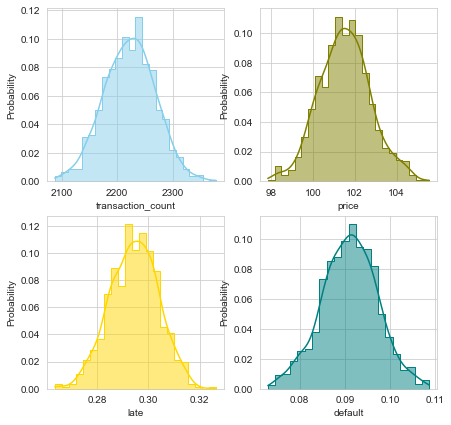

In [27]:
%matplotlib inline

sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(7, 7))

sns.histplot(data=_tmp, x="transaction_count", kde=True, color="skyblue", ax=axs[0, 0], element="step", stat="probability")
sns.histplot(data=_tmp.astype(np.float32), x="price", kde=True, color="olive", ax=axs[0, 1], element="step", stat="probability")
sns.histplot(data=_tmp, x="late", kde=True, color="gold", ax=axs[1, 0], element="step", stat="probability")
sns.histplot(data=_tmp, x="default", kde=True, color="teal", ax=axs[1, 1], element="step", stat="probability")

plt.show()

## Default and late payment on one transactions

### Late

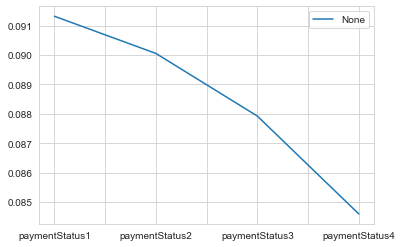

In [28]:
# late
_tmp = (df_trans.query("fraud==0").filter(regex='payment') == 1).astype(int)
_tmp.mean(axis=0).plot()
plt.legend() 
plt.show()

### Default

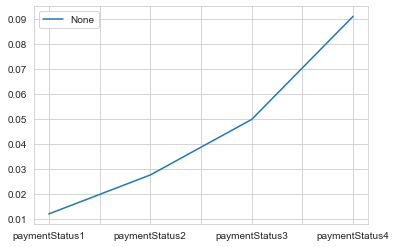

In [29]:
# default
_tmp = (df_trans.query("fraud==0").filter(regex='payment') == 2).astype(int)
_tmp.mean(axis=0).plot()
plt.legend() 
plt.show()

In [30]:
df_trans.query("fraud==0").query("paymentStatus1>1").head()

,transactionID,shopID,customerID,price,paymentStatus1,paymentStatus2,paymentStatus3,paymentStatus4,late,default,fraud
91,92,449,455927.0,96,2,2,2,2,0,1,0
136,137,796,447255.0,114,2,2,2,2,0,1,0
304,305,192,393571.0,192,2,2,2,2,0,1,0
323,324,608,378840.0,118,2,2,2,2,0,1,0
430,431,102,236139.0,89,2,2,2,2,0,1,0


### Transaction payment instalments

### First late, next late

In [31]:
def check_dependency(x_0, x_1, name='paymentStatus1', test=False):
    if test:
        table = [x_0,x_1]
    else:
        table = [list(x_0.sum()),list(x_1.sum())]
    stat, p, dof, expected = chi2_contingency(table)
    print(table)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably independent')
    else:
        print('Probably dependent')
    if test:
        return None
    return x_0.mean().to_frame(name=f'{name}_0').join(x_1.mean().to_frame(name=f'{name}_1'))

In [32]:
_tmp_f0 = df_trans.query("fraud==0").loc[df_trans.paymentStatus1==0].filter(regex='paymentStatus[2-4]').apply(lambda x: x==1).astype(int)
_tmp_f1 = df_trans.query("fraud==0").loc[df_trans.paymentStatus1==1].filter(regex='paymentStatus[2-4]').apply(lambda x: x==1).astype(int)

check_dependency(_tmp_f0, _tmp_f1)

[[157382, 153374, 147757], [22530, 22275, 21235]]
stat=2.167, p=0.338
Probably independent


,paymentStatus1_0,paymentStatus1_1
paymentStatus2,0.087864,0.123492
paymentStatus3,0.085627,0.122094
paymentStatus4,0.082491,0.116394


### First late, next default

In [33]:
_tmp_f0 = df_trans.query("fraud==0").loc[df_trans.paymentStatus1==0].filter(regex='paymentStatus[2-4]').apply(lambda x: x==2).astype(int)
_tmp_f1 = df_trans.query("fraud==0").loc[df_trans.paymentStatus1==1].filter(regex='paymentStatus[2-4]').apply(lambda x: x==2).astype(int)

check_dependency(_tmp_f0, _tmp_f1)

[[28201, 68647, 143732], [2857, 6739, 13974]]
stat=3.685, p=0.158
Probably independent


,paymentStatus1_0,paymentStatus1_1
paymentStatus2,0.015744,0.015660
paymentStatus3,0.038325,0.036938
paymentStatus4,0.080244,0.076595


### Second late, next late

In [34]:
_tmp_s0 = df_trans.query("fraud==0").loc[df_trans.paymentStatus2==0].filter(regex='paymentStatus[3-4]').apply(lambda x: x==1).astype(int)
_tmp_s1 = df_trans.query("fraud==0").loc[df_trans.paymentStatus2==1].filter(regex='paymentStatus[3-4]').apply(lambda x: x==1).astype(int)

check_dependency(_tmp_s0, _tmp_s1)

[[153563, 147509], [22086, 21483]]
stat=1.483, p=0.223
Probably independent


,paymentStatus1_0,paymentStatus1_1
paymentStatus3,0.087120,0.122760
paymentStatus4,0.083685,0.119408


### Second late, next default

In [35]:
_tmp_s0 = df_trans.query("fraud==0").loc[df_trans.paymentStatus2==0].filter(regex='paymentStatus[3-4]').apply(lambda x: x==2).astype(int)
_tmp_s1 = df_trans.query("fraud==0").loc[df_trans.paymentStatus2==1].filter(regex='paymentStatus[3-4]').apply(lambda x: x==2).astype(int)

check_dependency(_tmp_s0, _tmp_s1)

[[40431, 115478], [3897, 11170]]
stat=0.030, p=0.863
Probably independent


,paymentStatus1_0,paymentStatus1_1
paymentStatus3,0.022937,0.021661
paymentStatus4,0.065513,0.062086


## Customers  transactions history

remove transactions connected with fraudulent shop, and withocut customerID

In [36]:
df_trans = df_trans.loc[df_trans.fraud==0].dropna(subset=['customerID']).reset_index(drop=True)

In [37]:
df_trans['rank']=df_trans.groupby("customerID")["transactionID"].rank("dense", ascending=True)

In [38]:
df_trans['default_lag1'] = df_trans. \
    set_index('rank'). \
    groupby('customerID')[['default']]. \
    shift(1).reset_index(drop=True)

df_trans['late_lag1'] = df_trans. \
    set_index('rank'). \
    groupby('customerID')[['late']]. \
    shift(1).reset_index(drop=True)

df_trans['price_lag1'] = df_trans. \
    set_index('rank'). \
    groupby('customerID')[['price']]. \
    shift(1).reset_index(drop=True)

In [39]:
df_trans.sort_values(['customerID','rank']).head()

,transactionID,shopID,customerID,price,paymentStatus1,paymentStatus2,paymentStatus3,paymentStatus4,late,default,fraud,rank,default_lag1,late_lag1,price_lag1
117899,119294,634,1.0,88,0,0,0,0,0,0,0,1.0,NaN,NaN,NaN
822744,832074,942,1.0,177,1,0,0,0,1,0,0,2.0,0.0,0.0,88.0
858829,868540,361,1.0,93,0,0,0,0,0,0,0,3.0,0.0,1.0,177.0
1678935,1697842,248,1.0,147,0,0,0,0,0,0,0,4.0,0.0,0.0,93.0
972463,983409,741,2.0,71,1,0,0,0,1,0,0,1.0,NaN,NaN,NaN


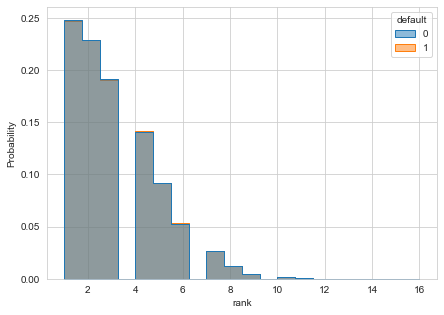

In [40]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(df_trans, x="rank", hue="default", ax=ax, alpha=0.5, bins=20, element="step", stat="probability", common_norm=False)
plt.show()

In [41]:
import time
start_time = time.time()

results = []
for i in range(1,7):
    print(f'do {i}')
    if len(results)==0:
        results += [df_trans. \
            set_index('rank'). \
            groupby('customerID')[['default_lag1','late_lag1','price_lag1']]. \
            rolling(i, min_periods=0).sum().reset_index()]
        results[-1].columns = ['customerID','rank',f'def_lst_{str(i).zfill(2)}',f'late_lst_{str(i).zfill(2)}',f'price_lst_{str(i).zfill(2)}']
    else:
        results += [df_trans. \
            set_index('rank'). \
            groupby('customerID')[['default_lag1','late_lag1','price_lag1']]. \
            rolling(i, min_periods=0).sum().reset_index().iloc[:,2:]]

        results[-1].columns = [f'def_lst_{str(i).zfill(2)}',f'late_lst_{str(i).zfill(2)}',f'price_lst_{str(i).zfill(2)}']
    print("--- %s seconds ---" % (time.time() - start_time))



do 1
--- 117.86662912368774 seconds ---
do 2
--- 242.78414106369019 seconds ---
do 3
--- 370.40085005760193 seconds ---
do 4
--- 475.53766918182373 seconds ---
do 5
--- 584.67067694664 seconds ---
do 6
--- 694.1100831031799 seconds ---


In [42]:
defaults = pd.concat(results, axis=1)

In [43]:
df_trans_all = df_trans.merge(defaults, on=['customerID','rank'], how='left')

**TAKE LAST TRANSACTION**

In [44]:
df_trans['rank_reverse'] = df_trans.groupby("customerID")["transactionID"].rank("dense", ascending=False)

In [45]:
df_trans_newest = df_trans.loc[df_trans.rank_reverse==1].reset_index(drop=True)
df_trans_history = df_trans.loc[df_trans.rank_reverse>1].reset_index(drop=True)

In [46]:
"""
df_trans_history_aggr = df_trans_history. \
    groupby('customerID'). \
    agg(
        trans_count=('default', 'count'),
        default_sum=('default', 'sum'),
        default_mean=('default', 'mean'),
        late_sum=('late', 'sum'),
        late_mean=('late', 'mean'),
        price_sum=('price', 'sum'),
        price_mean=('price', 'mean'),
).reset_index(drop=False)
"""
df_trans_history_aggr = df_trans_history. \
    groupby('customerID'). \
    agg(
        hist_trans_count=('default', 'count'),
        hist_default_sum=('default', 'sum'),
        hist_default_avg=('default', 'mean'),
        hist_late_sum=('late', 'sum'),
        hist_late_avg=('late', 'mean'),
        hist_price_sum=('price', 'sum'),
        hist_price_avg=('price', 'mean')
    ).reset_index(drop=False)

In [47]:
df_trans_newest = df_trans_newest.merge(df_trans_history_aggr, on='customerID', how='left')

In [48]:
df_trans_newest = df_trans_newest.merge(defaults, on=['customerID','rank'], how='left')

In [49]:
df_cust_trans = df_cust.merge(df_trans_newest, on = ['customerID'], how='left')

drop clients without transactions

In [50]:
df_cust_trans = df_cust_trans.dropna(subset=['default'])

## Check Address

In [51]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [52]:
addres_clusters_data = df_cust_trans.groupby('residentialAddress_clean'). \
    agg(
        trans_count=('default', 'count'),
        default_sum=('default', 'sum'),
        default_mean=('default', 'mean'),
        late_sum=('late', 'sum'),
        late_mean=('late', 'mean'),
        price_sum=('price', 'sum'),
        price_mean=('price', 'mean'),
).reset_index(drop=False).sort_values('default_mean')
addres_clusters_data

,residentialAddress_clean,trans_count,default_sum,default_mean,late_sum,late_mean,price_sum,price_mean
9242,Omeo Grove,28,0.0,0.000000,9.0,0.321429,2501.0,89.321429
5792,Hester Court,25,0.0,0.000000,7.0,0.280000,2165.0,86.600000
613,Assynt Street,26,0.0,0.000000,11.0,0.423077,3149.0,121.115385
5796,Hethorn Street,28,0.0,0.000000,7.0,0.250000,2998.0,107.071429
3203,Cribb Street,30,0.0,0.000000,5.0,0.166667,3050.0,101.666667
...,...,...,...,...,...,...,...,...
316,Amery Street,27,9.0,0.333333,5.0,0.185185,2179.0,80.703704
6921,Knapp Street,12,4.0,0.333333,5.0,0.416667,1268.0,105.666667
11117,Sixteenth Avenue,24,8.0,0.333333,6.0,0.250000,2238.0,93.250000
9186,Octave Court,17,6.0,0.352941,5.0,0.294118,1704.0,100.235294


### Clusters

In [53]:
scaler = MinMaxScaler()
X=scaler.fit_transform(addres_clusters_data.iloc[:,1:])

In [54]:
from sklearn.manifold import TSNE
data_sample_pca_embedded = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(X)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 13260 samples in 0.007s...
[t-SNE] Computed neighbors for 13260 samples in 0.898s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13260
[t-SNE] Computed conditional probabilities for sample 2000 / 13260
[t-SNE] Computed conditional probabilities for sample 3000 / 13260
[t-SNE] Computed conditional probabilities for sample 4000 / 13260
[t-SNE] Computed conditional probabilities for sample 5000 / 13260
[t-SNE] Computed conditional probabilities for sample 6000 / 13260
[t-SNE] Computed conditional probabilities for sample 7000 / 13260
[t-SNE] Computed conditional probabilities for sample 8000 / 13260
[t-SNE] Computed conditional probabilities for sample 9000 / 13260
[t-SNE] Computed conditional probabilities for sample 10000 / 13260
[t-SNE] Computed conditional probabilities for sample 11000 / 13260
[t-SNE] Computed conditional probabilities for sample 12000 / 13260
[t-SNE] Computed conditional probabilities for sa

<AxesSubplot:xlabel='x', ylabel='y'>

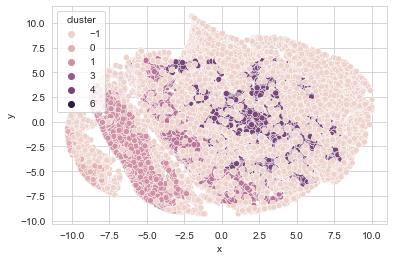

In [55]:

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA, IncrementalPCA

clustering = DBSCAN(eps=0.04, min_samples=20).fit(X)
set(clustering.labels_)

pca_clusters = pd.DataFrame(data_sample_pca_embedded, columns=['x','y']).assign(
    cluster=clustering.labels_, 
    dr=addres_clusters_data.iloc[:,1:].default_mean)
sns.scatterplot(data=pca_clusters, x="x", y="y", hue="cluster")



In [56]:
addres_clusters_data['cluster'] = clustering.labels_
addres_clusters_data.groupby('cluster')['default_mean'].mean()

cluster
-1    0.107086
 0    0.000000
 1    0.035745
 2    0.069414
 3    0.068445
 4    0.110276
 5    0.124397
 6    0.145654
Name: default_mean, dtype: float64

In [57]:
#df_cust_trans = df_cust_trans.drop(columns=['cluster_x','cluster_y'])

In [58]:
df_cust_trans = df_cust_trans.merge(addres_clusters_data[['residentialAddress_clean','cluster']], on='residentialAddress_clean', how='left')

## What country and city

In [60]:
residentialAddress_geocoded = []
for adr in df_cust_trans.residentialAddress.sample(500, random_state=1).to_list():
    residentialAddress_geocoded += [geocoder.osm(adr.strip()).json]


In [61]:
_tmp = []
for k in residentialAddress_geocoded:
    _tmp += [pd.DataFrame.from_dict([k])]
pd_residentialAddress_geocoded = pd.concat(_tmp)

In [62]:
pd_residentialAddress_geocoded.country.value_counts()

Australia                      274
United States                  126
United Kingdom                  49
New Zealand / Aotearoa          19
Canada                          16
South Africa                     3
Nederland                        3
Deutschland                      3
België / Belgique / Belgien      2
Бългaрия                         1
Viti                             1
عمان                             1
Éire / Ireland                   1
Name: country, dtype: int64

In [63]:
pd_residentialAddress_geocoded.city.value_counts()

Brisbane City    254
London            15
New York           5
Manchester         5
Sydney             4
                ... 
Binghamton         1
Brampton           1
Roodepoort         1
Logan City         1
Tallahassee        1
Name: city, Length: 98, dtype: int64

### Are geo data  real and is there any "risky" neighbourhood?

In [64]:
sample = df_cust_trans.sample(5000, random_state=1)

In [65]:
l_residentialAddress_geocoded = []
for adr in sample.residentialAddress.to_list():
    l_residentialAddress_geocoded += [geocoder.osm(adr.strip()+" ,Brisbane, Australia").json]


In [66]:
_tmp = []
for k in l_residentialAddress_geocoded:
    _tmp += [pd.DataFrame.from_dict([k])]
pd_residentialAddress_geocoded = pd.concat(_tmp)

In [82]:
pd_residentialAddress_geocoded['default_sum'] = sample.default.to_list()

In [83]:
pd_residentialAddress_geocoded['residentialAddress_clean'] = sample.residentialAddress_clean.to_list()

<AxesSubplot:xlabel='lng', ylabel='lat'>

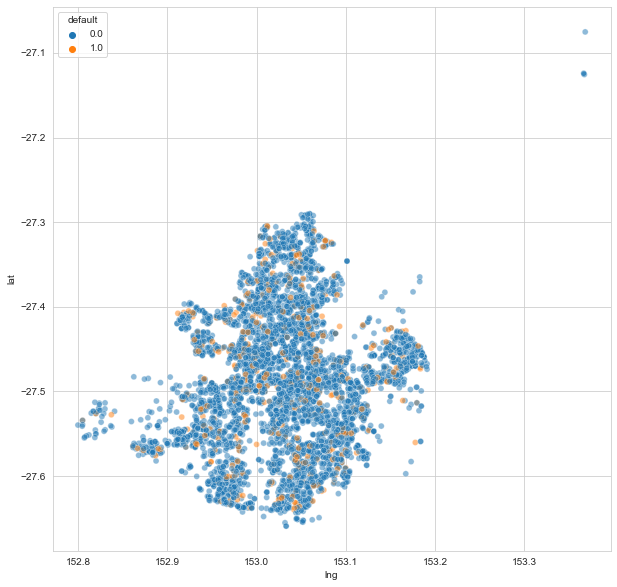

In [95]:

fig, ax = plt.subplots(figsize=(10,10))

sns.scatterplot(data=pd_residentialAddress_geocoded, x="lng", y="lat", hue="default", alpha=0.5, ax=ax)


In [90]:
pd_residentialAddress_geocoded.groupby('suburb').agg(
    trans_count=('default_sum', 'count'),
    uniqe_addreses=('residentialAddress_clean', 'nunique'),
    default_sum=('default_sum', 'sum')).reset_index().\
assign(dr = lambda x: x['default_sum'] / x['trans_count']).sort_values('dr')


,suburb,trans_count,uniqe_addreses,default_sum,dr
91,Larapinta,3,3,0.0,0.000000
130,Pullenvale,15,13,0.0,0.000000
129,Priestdale,1,1,0.0,0.000000
57,Fig Tree Pocket,27,22,0.0,0.000000
119,Nudgee Beach,3,1,0.0,0.000000
...,...,...,...,...,...
152,Stretton,17,14,5.0,0.294118
30,Carina Heights,13,12,4.0,0.307692
94,Lytton,6,5,2.0,0.333333
156,Taigum,24,20,8.0,0.333333


In [93]:
pd_residentialAddress_geocoded.groupby(['suburb','residentialAddress_clean']).agg(
    trans_count=('default', 'count'),
    default=('default', 'mean')).reset_index().sort_values('default').query("suburb=='Stretton'")



,suburb,residentialAddress_clean,trans_count,default
3155,Stretton,Birchwood Place,1,0.00
3156,Stretton,Cleveland Place,1,0.00
3158,Stretton,Eisenhower Street,1,0.00
3159,Stretton,Elm Court,1,0.00
3160,Stretton,Lacebark Street,1,0.00
3162,Stretton,Mckinley Court,1,0.00
3165,Stretton,Truman Court,1,0.00
3166,Stretton,Village Street,1,0.00
3167,Stretton,Willowleaf Close,1,0.00
3157,Stretton,Compton Road,4,0.25


## Create addresses "risk rank"

this way we can transfer informaction from current clients to new credit application

In [51]:
df_cust_trans.columns

Index(['customerID', 'sex', 'age', 'residentialAddress', 'postalAddress',
       'income', 'residentialAddress_clean', 'postalAddress_clean',
       'same_address', 'transactionID', 'shopID', 'price', 'paymentStatus1',
       'paymentStatus2', 'paymentStatus3', 'paymentStatus4', 'late', 'default',
       'fraud', 'rank', 'default_lag1', 'late_lag1', 'price_lag1',
       'rank_reverse', 'hist_trans_count', 'hist_default_sum',
       'hist_default_avg', 'hist_late_sum', 'hist_late_avg', 'hist_price_sum',
       'hist_price_avg', 'def_lst_01', 'late_lst_01', 'price_lst_01',
       'def_lst_02', 'late_lst_02', 'price_lst_02', 'def_lst_03',
       'late_lst_03', 'price_lst_03', 'def_lst_04', 'late_lst_04',
       'price_lst_04', 'def_lst_05', 'late_lst_05', 'price_lst_05',
       'def_lst_06', 'late_lst_06', 'price_lst_06'],
      dtype='object')

In [52]:
_tmp = df_cust_trans.groupby('residentialAddress_clean')[['hist_default_sum','hist_trans_count']]. \
    sum().reset_index().assign(dr = lambda x: x['hist_default_sum']/x['hist_trans_count'])

<AxesSubplot:>

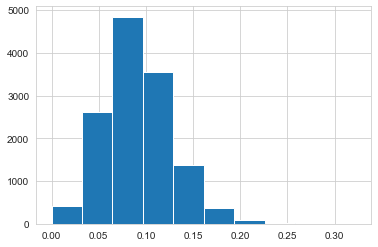

In [53]:
_tmp.dr.hist()

In [54]:
np.quantile(_tmp.dr, [i/10 for i in list(range(1,10,2))], axis=0)

array([0.04860437, 0.07142857, 0.08834466, 0.10666667, 0.1372549 ])

In [55]:
bins = [-np.inf, 0.049, 0.071, 0.088, 0.107, 0.137, np.inf]

In [56]:
pd.cut(_tmp.dr, bins).cat.codes

0        4
1        0
2        2
3        4
4        0
        ..
13255    5
13256    3
13257    3
13258    3
13259    3
Length: 13260, dtype: int8

In [57]:
geo_risk_rank = df_cust_trans.groupby('residentialAddress_clean')[['hist_default_sum','hist_trans_count']]. \
    sum().reset_index().assign(geo_risk_rank = lambda x: pd.cut(x['hist_default_sum']/x['hist_trans_count'], bins).cat.codes)


In [58]:
df_cust_trans = df_cust_trans.merge(geo_risk_rank[['residentialAddress_clean','geo_risk_rank']], on='residentialAddress_clean', how='left')

In [59]:
df_cust_trans

,customerID,sex,age,residentialAddress,postalAddress,income,residentialAddress_clean,postalAddress_clean,same_address,transactionID,...,def_lst_04,late_lst_04,price_lst_04,def_lst_05,late_lst_05,price_lst_05,def_lst_06,late_lst_06,price_lst_06,geo_risk_rank
0,1,male,25,28 Irvine Place,28 Irvine Place,NaN,Irvine Place,Irvine Place,1,1697842.0,...,0.0,1.0,358.0,0.0,1.0,358.0,0.0,1.0,358.0,4
1,2,male,19,72 Bertha Street,72 Bertha Street,43200.0,Bertha Street,Bertha Street,1,1834257.0,...,0.0,1.0,332.0,0.0,1.0,528.0,0.0,2.0,599.0,2
2,3,female,22,63 Ladberry Street,63 Ladberry Street,70200.0,Ladberry Street,Ladberry Street,1,1974624.0,...,0.0,0.0,442.0,1.0,0.0,508.0,1.0,0.0,577.0,1
3,4,other,24,98 Linneman Close,98 Linneman Close,93900.0,Linneman Close,Linneman Close,1,1536291.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,5,male,53,56 Salonica Road,56 Salonica Road,77000.0,Salonica Road,Salonica Road,1,661121.0,...,2.0,2.0,289.0,2.0,2.0,289.0,2.0,2.0,289.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490491,499996,male,68,95 Argyle Parade,95 Argyle Parade,40500.0,Argyle Parade,Argyle Parade,1,665043.0,...,0.0,0.0,173.0,0.0,0.0,173.0,0.0,0.0,173.0,4
490492,499997,female,22,34 Bearke Place,34 Bearke Place,44900.0,Bearke Place,Bearke Place,1,1756533.0,...,0.0,0.0,181.0,0.0,0.0,181.0,0.0,0.0,181.0,2
490493,499998,male,27,95 Glenhurst Street,95 Glenhurst Street,48700.0,Glenhurst Street,Glenhurst Street,1,1628579.0,...,0.0,0.0,354.0,0.0,0.0,354.0,0.0,0.0,354.0,0
490494,499999,male,55,34 Kiandra Close,34 Kiandra Close,7600.0,Kiandra Close,Kiandra Close,1,1722718.0,...,0.0,0.0,512.0,0.0,0.0,664.0,0.0,0.0,664.0,1


# Model - initial model only to get intuition about model features

In [60]:
df_cust_trans_new_cust.columns

NameError: name 'df_cust_trans_new_cust' is not defined

In [ ]:
cat = ['sex','shopID','residentialAddress_clean','postalAddress_clean','same_address','cluster']
numerical = ['age','income', 'price',  'rank', 'trans_count',
       'default_sum', 'default_mean', 'late_sum', 'late_mean', 'price_sum',
       'price_mean', 'def_lst_01', 'late_lst_01', 'price_lst_01', 'def_lst_02',
       'late_lst_02', 'price_lst_02', 'def_lst_03', 'late_lst_03',
       'price_lst_03', 'def_lst_04', 'late_lst_04', 'price_lst_04',
       'def_lst_05', 'late_lst_05', 'price_lst_05',
       'def_lst_06', 'late_lst_06', 'price_lst_06']
target_def = 'default'
target_late = 'late'

In [ ]:
import numpy as np
from category_encoders import *

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn import metrics

import lightgbm as lgb

In [ ]:
pipe_new = ColumnTransformer([
        ('num','passthrough',numerical),
        ('te', WOEEncoder(), cat),
    ])

pipe_old= ColumnTransformer([
        ('num','passthrough',numerical),
        ('te', WOEEncoder(), cat),
    ])

In [ ]:
df_cust_trans_new_cust = df_cust_trans.loc[df_cust_trans['rank']==1].reset_index(drop=True)
df_cust_trans_old_cust = df_cust_trans.loc[df_cust_trans['rank']>1].reset_index(drop=True)

In [ ]:
df_tr_cust_trans_new_cust = pipe_new.fit_transform(df_cust_trans_new_cust, df_cust_trans_new_cust.default)
df_tr_cust_trans_old_cust= pipe_old.fit_transform(df_cust_trans_old_cust, df_cust_trans_old_cust.default)


In [ ]:
d_train_new = lgb.Dataset(
    df_tr_cust_trans_new_cust, 
    label=df_cust_trans_new_cust.default, 
    feature_name=pipe_new.get_feature_names())

d_train_old = lgb.Dataset(
    df_tr_cust_trans_old_cust, 
    label=df_cust_trans_old_cust.default, 
    feature_name=pipe_old.get_feature_names())


In [ ]:
lgb_params = {#"learning_rate": 0.01,
              #"num_leaves": 16,
              #"min_data_in_leaf": 20,
              #"max_depth": 20,
              #"boosting": "gbdt",
              "num_iterations": 500,
              #"bagging_fraction": 0.6,
              #"feature_fraction": 1.0,
              "seed": 42,
              "num_threads": -1,
              "objective": "binary", 
              "metric": "auc"
              }

In [ ]:
cv_results = lgb.cv(lgb_params, d_train_new, nfold=5, verbose_eval=20, early_stopping_rounds=40)

In [ ]:
model_old = lgb.train(lgb_params, d_train_new)
fig, ax2 = plt.subplots(figsize=(10,10))
lgb.plot_importance(model_old, max_num_features=15, ax=ax2, importance_type = 'gain')

In [ ]:
cv_results = lgb.cv(lgb_params, d_train_old, nfold=5, verbose_eval=20, early_stopping_rounds=40)

In [ ]:
model_old = lgb.train(lgb_params, d_train_old)
fig, ax2 = plt.subplots(figsize=(10,10))
lgb.plot_importance(model_old, max_num_features=15, ax=ax2, importance_type = 'gain')